- Compute the second spatial derivative of the pressure fiel using Fourier transform

## Equations

In this section we are goint to show the solution of the 1D acoustic wave equation in homogeneous media by mean the **Fourier pseudo-spectral method**. 
$$
\partial^2_t p(x,t) = c(x)^2 \partial^2_xp(x,t) + s(x,t). \label{eq1}\tag{1}
$$

In this method, the Fourier method allows to calculate exact n-th derivatives on a regular grid (to machine precision). This result is combined with the classical time extrapolation schemes leadind to the result that we are searching for. 

Additionally, we know that the source term:

$$
S(x,t) = \delta(x-x_s)f(t)  \label{eq6}\tag{6}
$$

In [1]:
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from scipy import signal


**1. Fourier derivative method**
The second derivative is computed by multuplying the spatial Fourier transform of the pressure field $P(k,t)$ with (ik)^2

$$
\partial_x^2 p(x,t) = \mathfrak{F}^{-1}[(ik)^2P(k,t)]=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}(ik)^2 P(k,t) e^{ikx} dk
$$

where $k$ is the wavenumber and $\mathfrak{F}^{-1}$ is the IFT

In [2]:
def fourier_second_derivative(f, dx):
    nx = np.size(f)                                 # lenght of the vector f
    kmax = np.pi / dx                               # Initialize k vector to Nyquist wavenumber
                                                    # (recall fftpack.fftshift)
    dk = kmax / (nx/2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[:int(nx/2)] * dk             # This is for the even 
    k[int(nx/2) :]= k[:int(nx/2)] - kmax            # This is for the odd


    # Fourier derivative

    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))

    return df_num

**2. Initialization of setup**

In [3]:
# Basic parameters
# ------------------------------------
nt = 3500                                                                # Number of time steps
c = 343.                                                                 # acoustic velocity [m/s]
eps = 0.2                                                                # stability limit
isnap = 50                                                               # snapshot frequency
isx = 1250                                                               # source isolation 
f0 = 60.                                                                 # frequency [Hz](div by 5)
nx = 2024                                                                # number of gris points

# Pressure field inizialization 

p = np.zeros(nx) ; pnew = p ; pold = p ; d2p = p ; dp = p                # 3- points final difference operator
ap = np.zeros(nx) ; apnew = ap ; apold = ap ; ad2p = ap ; adp = ap       # 5- points final difference operator
sp = np.zeros(nx) ; spnew = sp ; spold = sp ; sd2p = sp ; sdp = sp       # Fourier


dx = 1250./(nx -1)                                                       # Calculate the space increment - Grid
x = np.arange(0, nx)*dx                                                  # initialize space coordinates
dt = eps*dx/c                                                            # calculate time step for stability criterion



**3. Source initialization**

In [4]:
# Source time function 

t = np.arange(1, nt+1)*dt
T0 = 1./f0
tmp = signal.ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

# Spatial source funtion 

sigma = 2*dx
x0 = x[isx - 1]
sg = np.exp(-1/sigma**2 * (x - x0)**2); sg = sg/np.amax(sg)

**4. Time Extrapolation**


The extrapolation scheme for $p_i^{n+1}$:


$$
p_i^{n+1} = dt^2 c_i^2 \partial_x^2[p^n_{j+1} - 2p_j^n +p_{j-1}^n] + 2p_j^n - p_j^{n-1} +S_j^n dt^2 \label{eq2}\tag{2}
$$

Similarly for the space derivative:

1. The three point difference operator 

$$
\partial_x^2 p(x,t) = \frac{p(x + dx, t) - 2p(x,t) + p(x - dx, t)}{dx^2} \label{eq3}\tag{3}
$$


1. The five point difference operator 

$$
\partial_x^2 p(x,t) = \frac{-p(x + 2dx, t)+ 16p(x + dx, t) - 30p(x,t) + 16p(x - dx, t) + 16p(x - 2dx, t) - p(x - 2dx, t) }{12dx^2} \label{eq4}\tag{4}
$$

**Numerical dispersion**. One of the main features of the Fourier method is the low numerical dispersion in comparison with the dispersion obtained using the difference method. 


<IPython.core.display.Javascript object>


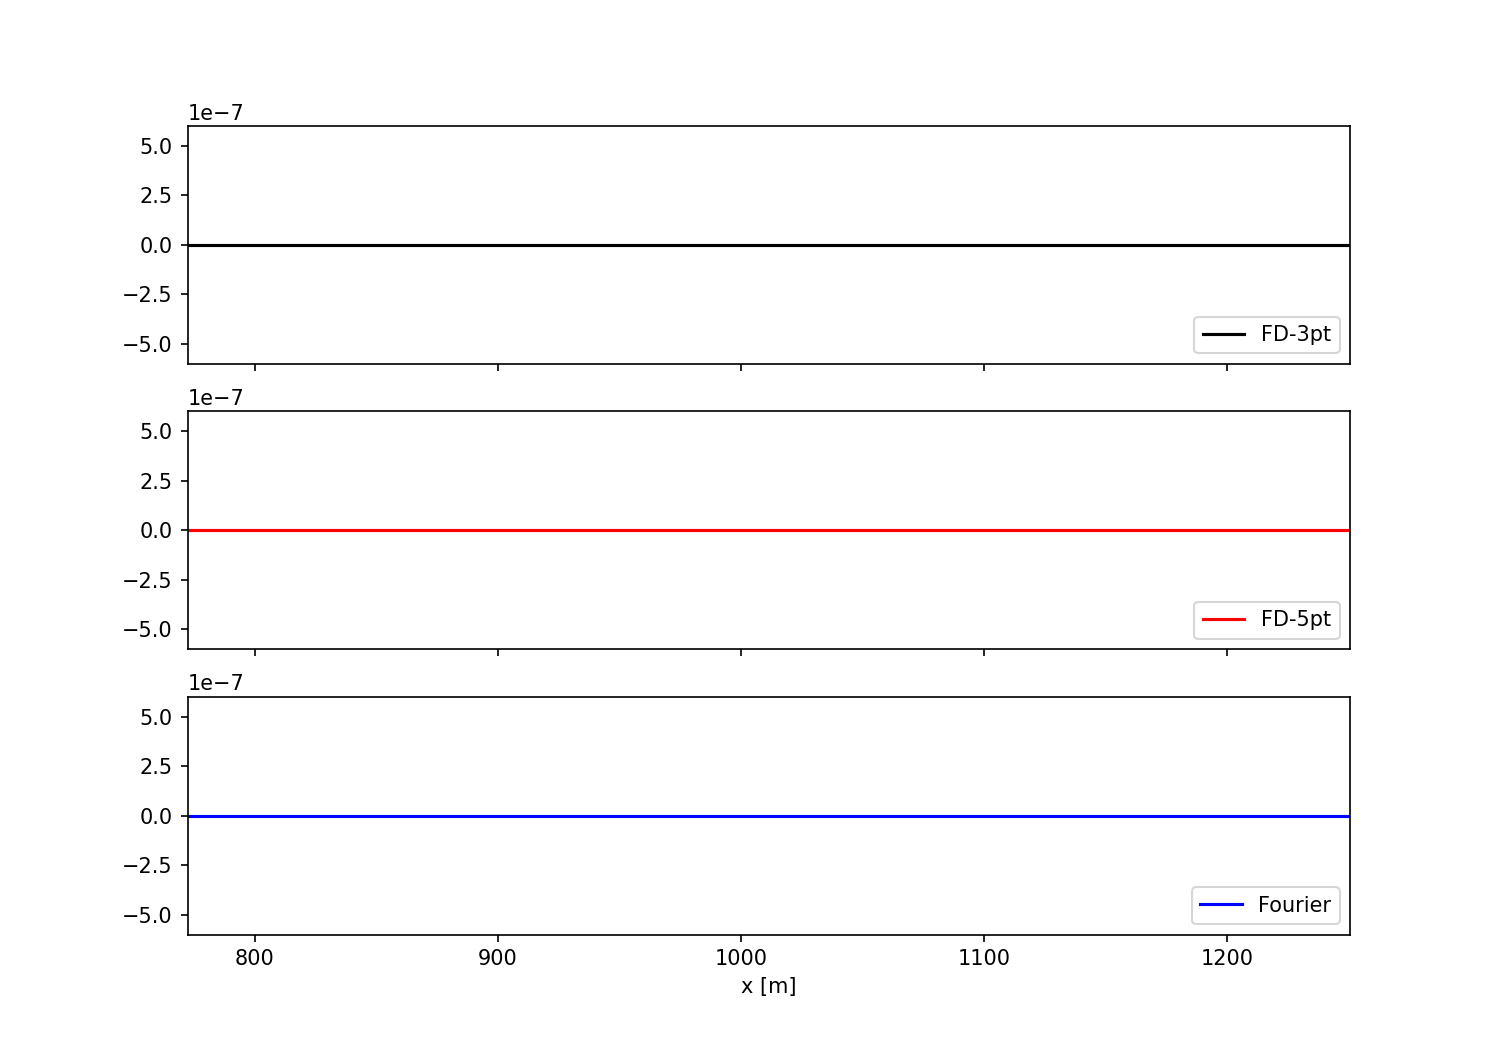

In [5]:
# Initialize animated plot

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex = True, sharey = True, figsize=(10,7))
line1 = ax1.plot(x[isx:], p[isx:], 'k', lw=1.5, label='FD-3pt')
line2 = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5, label='FD-5pt')
line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5, label='Fourier')
ax1.axis([isx*dx, nx*dx, -6E-7, 6E-7]); ax3.set_xlabel('x [m]')
ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=4)

plt.ion()                                                          #  set intercative mode
plt.show()



In [6]:
# Time extrapolation

for it in range(nt):
    # Fourier pseudo-spectral method 
    sd2p = fourier_second_derivative(sp,dx)                                #2nd space derivative
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p                             # time extrapolation 
    spnew = spnew + sg*src[it]*dt**2                                       # Add sources
    
    spold, sp = sp, spnew                                                  # time levels
    sp[1] = 0; sp[nx-1] = 0                                                # set boundaries pressure free
    
    # ----------------------------------------
    # Finite Differences Method 5pt
    # ----------------------------------------
    for i in range(2, nx-2):
        ad2p[i] = (-1/12*ap[i+2] + 4/3*ap[i+1] - 5/2*ap[i] \
                   + 4/3*ap[i-1] - 1/12*ap[i-2])/dx**2                     # Space derivative        
    apnew = 2*ap - apold + dt**2 * c**2 * ad2p                             # Time Extrapolation    
    apnew = apnew + sg*src[it]*dt**2                                       # Add source    
    apold, ap = ap, apnew                                                  # Time levels
    ap[0] = 0; ap[nx-1] = 0                                                # set boundaries pressure free
    
    # --------------------------------------   
    # Animation plot. Display solution
    if not it % isnap: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l
            
        # -------------------------------------- 
        # Display lines
        line1 = ax1.plot(x[isx:], p[isx:], 'k', lw=1.5)
        line2 = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5)
        line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5)
        plt.gcf().canvas.draw()
plt.show()